<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


In [0]:
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')

from sys import getsizeof

import os
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/ENSaver/building_metadata.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/model_nn.h5
/content/drive/My Drive/Colab Notebooks/ENSaver/model_nn.json
/content/drive/My Drive/Colab Notebooks/ENSaver/out_file_int.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/sample_submission (1).csv
/content/drive/My Drive/Colab Notebooks/ENSaver/sample_submission.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/test.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/train.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/weather_test.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/weather_train.csv


In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater

#  Подготовка данных

df = pd.read_csv(DIR + "train.csv", engine = 'python')
#df_test = pd.read_csv(DIR + "test.csv", engine = 'python')

df['timestamp'] = pd.to_datetime(df['timestamp'])
#df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

#Очистка от корявых данных
df = df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

#df_train['is_test'] = 0
#df_test['is_test'] = 1

df['meter_reading'] = np.log1p(df['meter_reading'])

#df = pd.concat([df_train, df_test], sort=False)

df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

#df_train['weekends'] = (df_train['weekday'] >= 6) * 1

In [0]:
building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

building_df['primary_use'] = building_df['primary_use'].astype('category')
building_df = pd.get_dummies(building_df)

df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
df.head(5)
del building_df

In [0]:
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
#weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
df_weather = df_weather.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
df = pd.merge(df, df_weather, how = 'left', on = ['site_id','timestamp'])
del df_weather

In [0]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [0]:
# Добавление медианы по метрике постройки

df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
df_median.name = 'building_meter_median'

df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])

del df_median 

In [0]:
#Вывести кол-во пустот по полям
cols = list(df.columns[:3]) + list(df.columns[4:])

for col in cols:
  if np.sum(df[col].isnull()) > 0:
    print(col)
    print(np.sum(df[col].isnull()))
    df[col].fillna( df[col].mean(), inplace = True)
#df_train.isnull()
#df_train.columns ==  df_test.columns[1:]


year_built
12127645
floor_count
16362953
air_temperature
90495
cloud_coverage
567396
dew_temperature
90495
precip_depth_1_hr
1736593
sea_level_pressure
869690
wind_direction
90495
wind_speed
90495


In [0]:
df['year_built'].fillna( df['year_built'].mean(), inplace = True)

In [0]:
# Нормализация

# cols = df.columns[5:]

# for col in cols:
#   x_min = df[col].min()
#   x_max = df[col].max()
#   if ((x_min != 0) | (x_max != 1)):
#     df[col] = (df[col] - x_min) / (x_max-x_min)

In [0]:
from keras.models import Sequential

from keras.layers import Dense
from keras.initializers import TruncatedNormal, Constant
from keras.regularizers import l1
from keras.optimizers import Adam
import keras.backend as K

from keras. callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.utils import plot_model
from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

Using TensorFlow backend.


In [0]:
def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

    

In [0]:
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'hour_cos',
       'hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet', 'year_built', 'floor_count', 'primary_use_ID',
       'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'building_meter_median'],
      dtype='object')

In [0]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet', 'year_built', 'floor_count', #'primary_use_ID',
       'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'building_meter_median']

In [0]:
reg = 0.00001
batch_size = 1024
epochs = 70

earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')

init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
bias = Constant(value = 1e-3)

opt = Adam(lr = 0.0003)

nn = Sequential()
nn.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = init, bias_initializer = bias))
nn.add(Dense(100, activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = init, bias_initializer = bias))
nn.add(Dense(1, activation = 'relu', kernel_regularizer=l1(reg), kernel_initializer = init, bias_initializer = bias))

nn.compile(optimizer = opt, loss = 'mse')

hist = nn.fit( df[In_Columns], df[Out_Columns], batch_size = batch_size, verbose = 1
                 , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]) #, validation_data=(X_val, y_val)


Epoch 1/70
19869886/19869886 [==============================] - 87s 4us/step - loss: 3.9242
Epoch 2/70

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



  668672/19869886 [>.............................] - ETA: 2:00 - loss: 3.8251

In [0]:
hist = nn.fit( X_train, y_train, batch_size = 200000, verbose = 1
                 , epochs = 70, shuffle = True, validation_data=(X_val, y_val), callbacks=[earlyStopping, reduce_lr_loss])


Train on 13544787 samples, validate on 6671313 samples
Epoch 1/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9631 - val_loss: 0.9545
Epoch 2/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9552 - val_loss: 0.9593
Epoch 3/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9596 - val_loss: 0.9531
Epoch 4/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9585 - val_loss: 0.9600
Epoch 5/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9508 - val_loss: 0.9560
Epoch 6/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9525 - val_loss: 0.9524
Epoch 7/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9525 - val_loss: 0.9522
Epoch 8/70
13544787/13544787 [==============================] - 33s 2us/step - loss: 0.9474 - val_loss: 0.9483
Epoch 9/70
13544787/13544787 [===========================

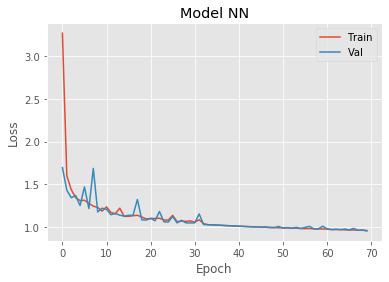

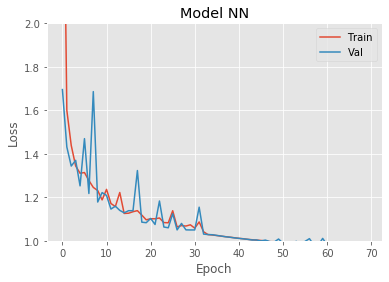

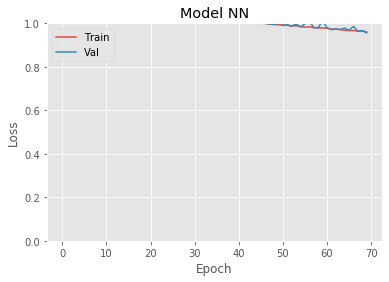

In [0]:
show_plot(hist) 

In [0]:
def save_model(model, dir = os.getcwd(), name = 'model'):
  model_json = model.to_json()
  with open(os.path.join(dir,name+'.json'), 'w') as json_file:
      json_file.write(model_json)
  model.save_weights(os.path.join(dir,name+'.h5'))
  print("Saved model to disk.")

In [0]:
save_model(nn, DIR, 'model_nn')

Saved model to disk.


In [0]:
from keras.models import model_from_json

def load_model(dir = os.getcwd(), name = 'model'):
  json_file = open(os.path.join(dir,name+'.json'), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights(os.path.join(dir,name+'.h5'))
  print("Loading is complete.")
  return model

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)










Loading is complete.



In [0]:
from sklearn.utils import shuffle

In [0]:
k = nn.evaluate(X_val, y_val, batch_size = 800000, verbose = 0)
print(k)
for i in range(X_val.shape[1]):
    X_val_2 = X_val.copy()
    s = shuffle(X_val_2.iloc[:,i])
    s.index = X_val_2.index
    X_val_2.iloc[:, i] = s
    print('{}: {:2.5}'.format(cols[i], nn.evaluate(X_val_2, y_val, batch_size = 800000, verbose = 0) - k))
    X_val_2 = None

0.9596900019018605
building_median: 5.819
meter_0: 0.58292
meter_1: 0.972
meter_2: 0.74869
meter_3: 0.37119
site_id: 0.2405
square_feet: 0.30628
site_id_0: 1.0401
site_id_1: 0.1221
site_id_2: 0.30877
site_id_3: 0.18319
site_id_4: 0.062723
site_id_5: 0.074246
site_id_6: 0.1025
site_id_7: 0.20131
site_id_8: 0.043794
site_id_9: 0.28214
site_id_10: 0.057954
site_id_11: 0.01723
site_id_12: 0.013731
site_id_13: 0.24857
site_id_14: 0.30342
site_id_15: 0.13226
primary_use_Education: 0.3433
primary_use_Entertainment/public assembly: 0.15548
primary_use_Food sales and service: 0.014033
primary_use_Healthcare: 0.061511
primary_use_Lodging/residential: 0.15654
primary_use_Manufacturing/industrial: 0.016794
primary_use_Office: 0.25216
primary_use_Other: 0.017878
primary_use_Parking: 0.03211
primary_use_Public services: 0.11415
primary_use_Religious worship: 0.0012776
primary_use_Retail: 0.0078331
primary_use_Services: 0.018232
primary_use_Technology/science: 0.0096781
primary_use_Utility: 0.0033111

In [0]:
X_test.shape

(41697600, 45)

In [0]:
p = nn.predict(X_test, batch_size = 100000)

In [0]:
df_sample_submission['meter_reading'] = np.exp(p)-1

In [0]:
df_sample_submission.to_csv(DIR+'out_file_int.csv', index = False)

In [0]:
p[0:5]

array([[5.240274 ],
       [5.1473227],
       [5.0696645],
       [5.019961 ],
       [5.010914 ]], dtype=float32)

In [0]:
df_sample_submission.head()

,row_id,meter_reading
8784,0,187.721802
8785,129,170.970444
8786,258,158.120926
8787,387,150.405380
8788,516,149.041794


In [0]:
X_test.head()

,building_median,meter_0,meter_1,meter_2,meter_3,site_id,square_feet,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_id_13,site_id_14,site_id_15,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin
8784,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.500000,0.801938,0.099031,0.996487,0.440837
8785,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.982963,0.629410,0.801938,0.099031,0.996487,0.440837
8786,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.933013,0.750000,0.801938,0.099031,0.996487,0.440837
8787,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.853553,0.853553,0.801938,0.099031,0.996487,0.440837
8788,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000,0.933013,0.801938,0.099031,0.996487,0.440837


In [0]:
df_sample_submission['row_id'] = df_sample_submission['row_id'].astype('Int32')


In [0]:
df_sample_submission['meter_reading'] = df_sample_submission['meter_reading'].astype('Int32')


In [0]:
# df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
# train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)